In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import sys
sys.path.append('/home/chenzhao/useful/scripts/python/pyFFTps')
import pyFFTps

fname = './halo-c0000-BoxSize-250-Mgt1e11-redshift-0.txt'
### Now only support the single-precision float calculation
pos = np.loadtxt(fname).astype(np.float32)
# pind = np.random.randint(0, pos.shape[0], 100000)
# pos = pos[pind]

print("Loaded {:d} haloes.".format(pos.shape[0]))
Nmesh = 200
MAS = 'CIC'
BoxSize = 250 #Mpc/h
numden  = pos.shape[0] / BoxSize**3
print("Number density: {:.2e}".format(numden), "h^3/Mpc^3")
print("Nyquist frequency: {:.2e}".format(np.pi * Nmesh / BoxSize), "h/Mpc")

Loaded 513052 haloes.
Number density: 3.28e-02 h^3/Mpc^3
Nyquist frequency: 2.51e+00 h/Mpc


In [4]:
### calculate the isotropic shot noise
def IsotropicShotNoise(k, BoxSize, Nmesh, numden, MAS, interlaced):
    '''
    k: the wavenumber in unit of h/Mpc
    BoxSize: the size of the simulation box in unit of Mpc^3/h^3
    Nmesh: the number of cells per dimension
    MAS: the mass assignment scheme, e.g., 'CIC', 'TSC', 'PCS'
    numden: number density of the tracers in unit of h^3/Mpc^3
    interlaced: whether the density field is interlaced or not
    '''
    kH   = 2*np.pi*Nmesh/BoxSize
    if interlaced:
        cosk2 = np.cos(np.pi*k/kH/2)
        sink2 = np.sin(np.pi*k/kH/2)
        if   MAS == 'NGP': Ck = cosk2**2
        elif MAS == 'CIC': Ck = cosk2**4*(1 - 2/3 * sink2**2)
        elif MAS == 'TSC': Ck = cosk2**6*(1 - sink2**2 + 2/15 * sink2**4)
        elif MAS == 'PCS': Ck = cosk2**8*(1 - 4/3 * sink2**2 + 2/5 * sink2**4 - 4/315 * sink2**6)
        else: raise ValueError("MAS method not supported.")
    else:
        sink = np.sin(np.pi*k/kH)
        if   MAS == 'NGP': Ck = 1
        elif MAS == 'CIC': Ck = 1 - 2/3 * sink**2
        elif MAS == 'TSC': Ck = 1 - sink**2 + 2/15 * sink**4
        elif MAS == 'PCS': Ck = 1 - 4/3 * sink**2 + 2/5 * sink**4 - 4/315 * sink**6
        else: raise ValueError("MAS method not supported.")
    return Ck/numden

def MAWindow(k, BoxSize, Nmesh, MAS):
    '''
    k: the wavenumber in unit of h/Mpc
    BoxSize: the size of the simulation box in unit of Mpc^3/h^3
    Nmesh: the number of cells per dimension
    MAS: the mass assignment scheme, e.g., 'CIC', 'TSC', 'PCS'
    '''
    kH   = 2*np.pi*Nmesh/BoxSize
    MAS_index = {'NGP': 1, 'CIC': 2, 'TSC': 3, 'PCS': 4}
    return np.sinc(k/kH)**(MAS_index[MAS])

## No Interlacing

In [5]:
%%time
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=False, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
delta = delta / deltamean - 1
print('Check delta:', delta.min(), delta.mean(), delta.max())
pk0 = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=False, numeff=numden, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Time taken = 0.051 seconds

Check delta: -1.0 3.733444e-08 98.846245

Computing power spectrum of the field...
SN_index = 2,  numden = 0.032835 h^3/Mpc^3.
Time to complete loop = 0.36
Time taken = 0.45 seconds
CPU times: user 534 ms, sys: 63.8 ms, total: 598 ms
Wall time: 556 ms


In [6]:
%%time
### Not subtracting the shot noise
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=False, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
delta = delta / deltamean - 1
print('Check delta:', delta.min(), delta.mean(), delta.max())
pk00 = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=False, numeff=numden, SNFlag=False,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Time taken = 0.039 seconds

Check delta: -1.0 3.733444e-08 98.846245

Computing power spectrum of the field...
Time to complete loop = 0.36
Time taken = 0.45 seconds
CPU times: user 538 ms, sys: 49.2 ms, total: 587 ms
Wall time: 528 ms


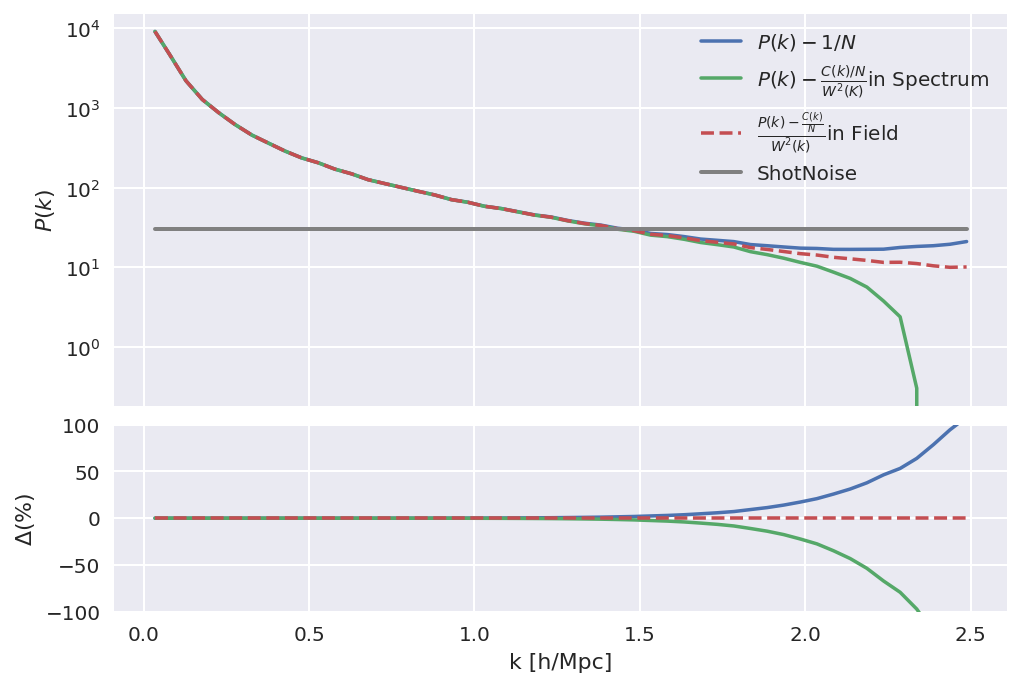

In [7]:
snwindow = IsotropicShotNoise(pk0[0], BoxSize, Nmesh, numden, MAS, False)
snwindow = snwindow / MAWindow(pk0[0], BoxSize, Nmesh, MAS)**2
with plt.style.context('seaborn'):
    grid = plt.GridSpec(3, 1, hspace=0.1)
    ax0 = plt.subplot(grid[0:2, 0])
    plt.plot(pk0[0], (pk00[1]-1/numden), label=r'$P(k)-1/N$')
    plt.plot(pk0[0], (pk00[1]-snwindow), label=r'$P(k)-\frac{C(k)/N}{W^2(K)} $in Spectrum')
    plt.plot(pk0[0], pk0[1], '--', label=r'$\frac{P(k)-\frac{C(k)}{N}}{W^2(k)} $in Field')
    plt.plot(pk0[0], 1/numden*np.ones_like(pk0[0]), 'gray', lw=2.0, label='ShotNoise')
    plt.legend()
    plt.yscale('log')
    plt.ylabel(r'$P(k)$')
    ax0.set_xticklabels([])
    plt.subplot(grid[2, 0])
    plt.plot(pk0[0], ((pk00[1]-1/numden)/pk0[1] - 1)*100)
    plt.plot(pk0[0], ((pk00[1]-snwindow)/pk0[1] - 1)*100)
    plt.plot(pk0[0], np.zeros_like(pk0[0]), '--')
    plt.ylim(-100, 100)
    plt.xlabel('k [h/Mpc]')
    plt.ylabel(r'$\Delta (\%)$')
    

## Interlacing

In [8]:
%%time
### interlacing
delta = np.zeros((Nmesh,Nmesh,Nmesh), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh**3
delta = delta / deltamean - 1
print('Check delta:', delta.min(), delta.mean(), delta.max())
pk1 = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=True, numeff=numden, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh, kbin=int(Nmesh/4)+1)


Using CIC mass assignment scheme
Interlacing the density field
Time taken = 0.750 seconds

Check delta: -7.2483673 2.6008607e-08 91.34477

Computing power spectrum of the field...
SN_index = 2,  numden = 0.032835 h^3/Mpc^3.
Subtracting shotnoise from the field in the interlaced case.
Time to complete loop = 0.48
Time taken = 0.56 seconds
CPU times: user 1.31 s, sys: 247 ms, total: 1.56 s
Wall time: 1.35 s


In [9]:
%%time
### 2 times Nmesh
Nmesh2 = 2*Nmesh
delta = np.zeros((Nmesh2,Nmesh2,Nmesh2), dtype=np.float32)
pyFFTps.MA(pos, delta, BoxSize, MAS=MAS, interlaced=True, threads=2, verbose=True)
deltamean = pos.shape[0]/Nmesh2**3
delta = delta / deltamean - 1
print('Check delta:', delta.mean())
pko = pyFFTps.Pk1D(delta, BoxSize, MAS=MAS, verbose=True, threads=2, 
                   interlaced=True, numeff=numden, SNFlag=True,
                   kmin=0.0, kmax=np.pi/BoxSize*Nmesh2, kbin=int(Nmesh2/4)+1)


Using CIC mass assignment scheme
Interlacing the density field


Time taken = 6.501 seconds

Check delta: 2.5730133e-08

Computing power spectrum of the field...
SN_index = 2,  numden = 0.032835 h^3/Mpc^3.
Subtracting shotnoise from the field in the interlaced case.
Time to complete loop = 3.85
Time taken = 4.61 seconds
CPU times: user 10.1 s, sys: 3.43 s, total: 13.5 s
Wall time: 11.4 s


In [10]:
from nbodykit.lab import ArrayCatalog, FFTPower

cat = np.zeros((pos.shape[0]), dtype=np.dtype([('Position', ('f4', 3))]))
cat['Position'] = pos
cat = ArrayCatalog(cat)

In [11]:
mesh = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic',
                   interlaced=True, compensated=True)
pknbinterlaced = FFTPower(mesh, mode='1d', 
                 dk=4*np.pi/BoxSize,kmin=0.0).power


In [12]:
mesh = cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, resampler='cic', 
                   interlaced=False, compensated=True)
pknb = FFTPower(mesh, mode='1d', 
                dk=4*np.pi/BoxSize,kmin=0.0).power


For Nbodykit, we consider the shotnoise as 1/N at the middle panel.

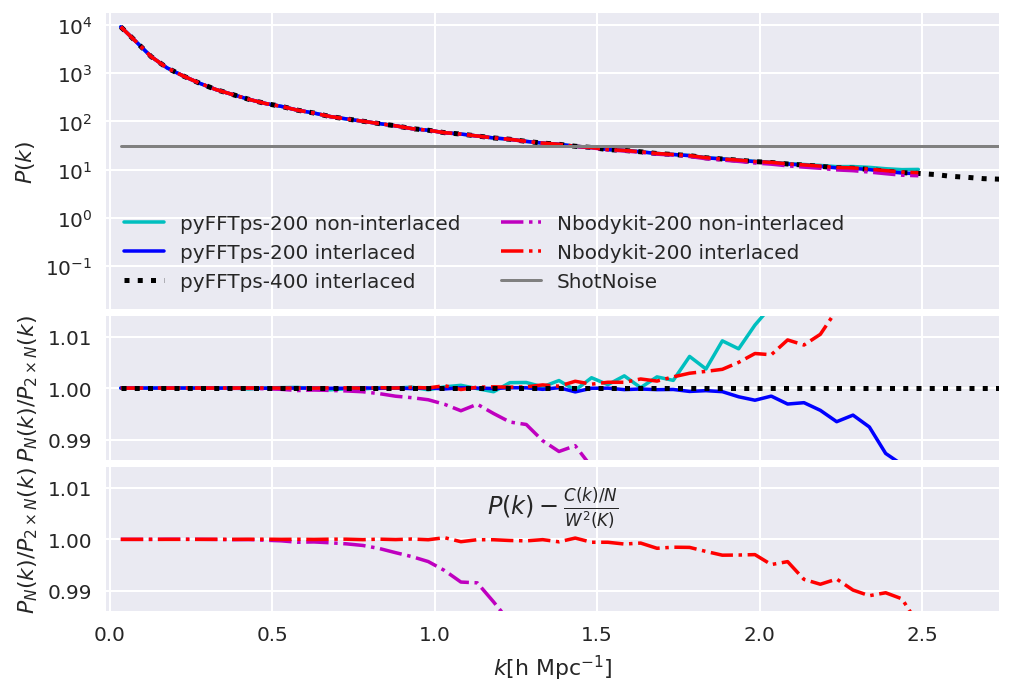

In [17]:
sn1 = IsotropicShotNoise(pk0[0], BoxSize, Nmesh, numden, MAS, False)
sn1 = sn1 / MAWindow(pk0[0], BoxSize, Nmesh, MAS)**2
sn2 = IsotropicShotNoise(pk0[0], BoxSize, Nmesh, numden, MAS, True)
sn2 = sn2 / MAWindow(pk0[0], BoxSize, Nmesh, MAS)**2
with plt.style.context('seaborn'):
    plt.rcParams['font.size'] = 16
    kind = pko[0] <= pk0[0].max()
    xlim = [-0.01, 1.1*pk0[0].max()]
    grid = plt.GridSpec(4,1,hspace=0.05)
    ax0 = plt.subplot(grid[:2,0])
    plt.plot(pk0[0], pk0[1], 'c-',  label='pyFFTps-%d non-interlaced'%Nmesh)
    plt.plot(pk1[0], pk1[1], 'b-', label='pyFFTps-%d interlaced'%Nmesh)
    plt.plot(pko[0], pko[1], 'k:', lw=2.5, label='pyFFTps-%d interlaced'%Nmesh2)
    plt.plot(pknb['k'], pknb['power'].real - 1/numden, 'm-.', label='Nbodykit-%d non-interlaced'%Nmesh)
    plt.plot(pknbinterlaced['k'], pknbinterlaced['power'].real - 1/numden, 'r-.', label='Nbodykit-%d interlaced'%Nmesh)
    plt.plot(pko[0], 1/numden*np.ones_like(pko[0]), 
             'gray', lw=1.5, label='ShotNoise')
    plt.legend(ncol=2)
    # plt.xscale('log')
    plt.yscale('log')
    ax0.set_xticklabels([])
    plt.xlim(xlim)
    # plt.ylim(0, 120)
    plt.ylabel(r'$P(k)$')
    ax1 = plt.subplot(grid[2,0])
    plt.plot(pk0[0], pk0[1]/pko[1][kind], 'c-')
    plt.plot(pk0[0], pk1[1]/pko[1][kind], 'b-')
    plt.plot(pk0[0], (pknb['power'].real - 1/numden)/pko[1][kind], 'm-.')
    plt.plot(pk0[0], (pknbinterlaced['power'].real-1/numden)/pko[1][kind], 'r-.')
    plt.plot(pko[0], pko[1]/pko[1], 'k:', lw=2.5)
    # plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim([0.986,1.014])
    plt.ylabel(r'$P_{N}(k)/P_{2\times N}(k)$')
    ax1.set_xticklabels([])
    plt.subplot(grid[3,0])
    plt.plot(pk0[0], (pknb['power'].real - sn1)/pko[1][kind], 'm-.')
    plt.plot(pk0[0], (pknbinterlaced['power'].real-sn2)/pko[1][kind], 'r-.')
    plt.title(r'$P(k)-\frac{C(k)/N}{W^2(K)}$', y=0.6)
    plt.ylabel(r'$P_{N}(k)/P_{2\times N}(k)$')
    plt.xlabel(r'$k [{\rm h\ Mpc^{-1}}]$')
    plt.xlim(xlim)
    plt.ylim([0.986,1.014])
    